In [1]:
import numpy as np
import pandas as pd
import scorecardpy as sc
import warnings
warnings.filterwarnings('ignore')

## 导入数据

In [2]:
dat = sc.germancredit()
dt_s = sc.var_filter(dat, y="creditability")

[INFO] filtering variables ...


## 数据划分

In [3]:
train, test = sc.split_df(dt_s, 'creditability').values()

## 变量分箱

In [4]:
bins = sc.woebin(dt_s, y="creditability")

[INFO] creating woe binning ...


In [5]:
bins['purpose']

,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,purpose,"retraining%,%car (used)",112,0.112,94,18,0.160714,-0.805625,0.059846,0.152924,"retraining%,%car (used)",False
1,purpose,radio/television,280,0.280,218,62,0.221429,-0.410063,0.042959,0.152924,radio/television,False
2,purpose,"furniture/equipment%,%domestic appliances%,%bu...",608,0.608,388,220,0.361842,0.279920,0.050119,0.152924,"furniture/equipment%,%domestic appliances%,%bu...",False


In [6]:
bins['age_in_years']

,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,age_in_years,"[-inf,26.0)",190,0.190,110,80,0.421053,0.528844,0.057921,0.130499,26.0,False
1,age_in_years,"[26.0,28.0)",101,0.101,74,27,0.267327,-0.160930,0.002529,0.130499,28.0,False
2,age_in_years,"[28.0,35.0)",257,0.257,172,85,0.330739,0.142455,0.005359,0.130499,35.0,False
3,age_in_years,"[35.0,37.0)",79,0.079,67,12,0.151899,-0.872488,0.048610,0.130499,37.0,False
4,age_in_years,"[37.0,inf)",373,0.373,277,96,0.257373,-0.212371,0.016080,0.130499,inf,False


{'status_of_existing_checking_account': <Figure size 432x288 with 2 Axes>,
 'other_debtors_or_guarantors': <Figure size 432x288 with 2 Axes>,
 'installment_rate_in_percentage_of_disposable_income': <Figure size 432x288 with 2 Axes>,
 'credit_history': <Figure size 432x288 with 2 Axes>,
 'credit_amount': <Figure size 432x288 with 2 Axes>,
 'housing': <Figure size 432x288 with 2 Axes>,
 'purpose': <Figure size 432x288 with 2 Axes>,
 'present_employment_since': <Figure size 432x288 with 2 Axes>,
 'savings_account_and_bonds': <Figure size 432x288 with 2 Axes>,
 'age_in_years': <Figure size 432x288 with 2 Axes>,
 'duration_in_month': <Figure size 432x288 with 2 Axes>,
 'property': <Figure size 432x288 with 2 Axes>,
 'other_installment_plans': <Figure size 432x288 with 2 Axes>}

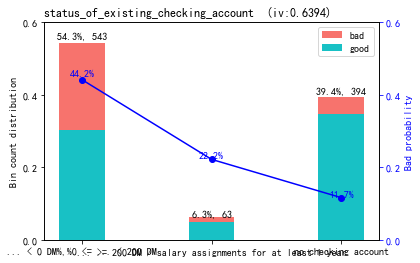

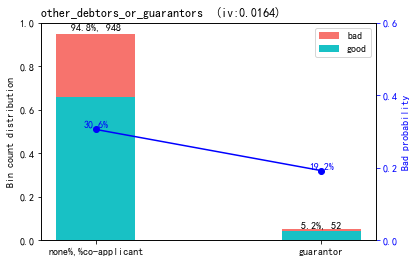

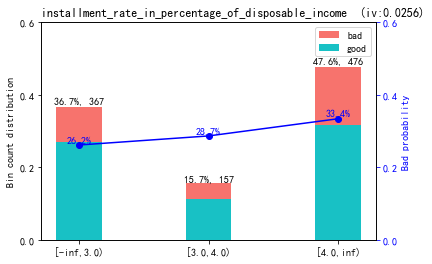

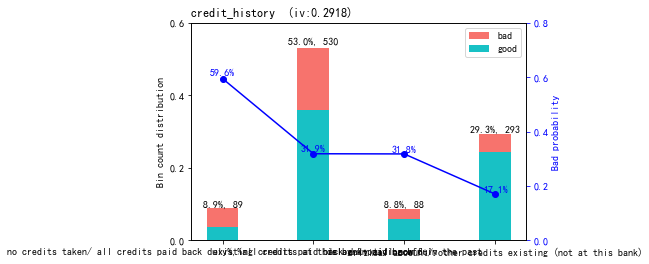

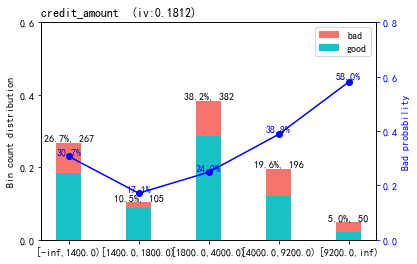

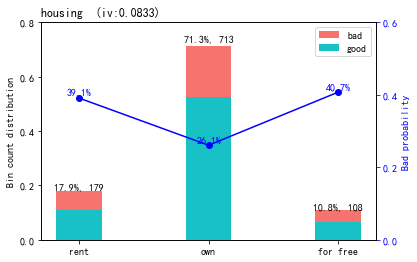

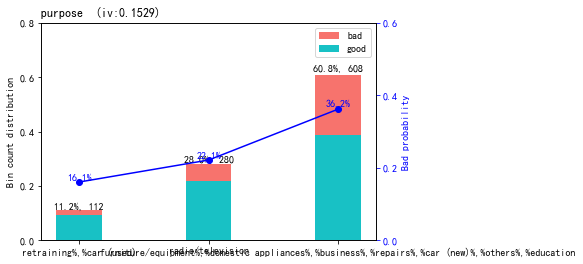

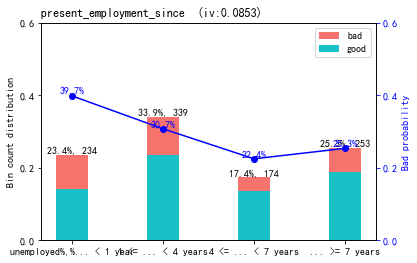

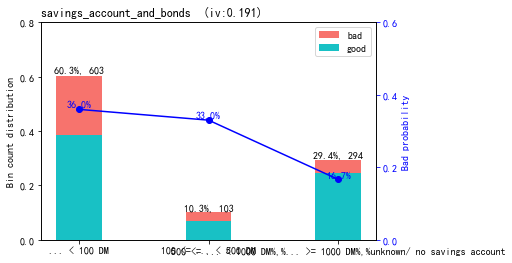

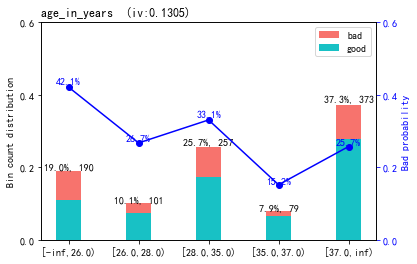

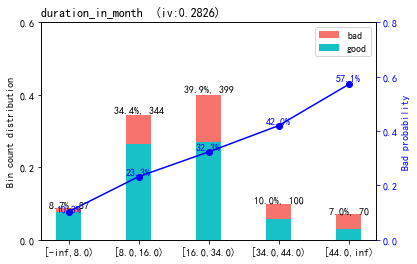

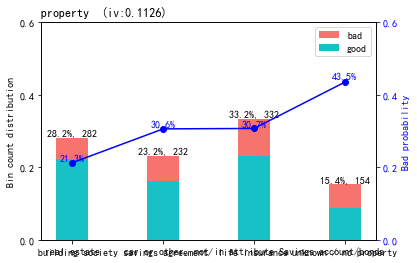

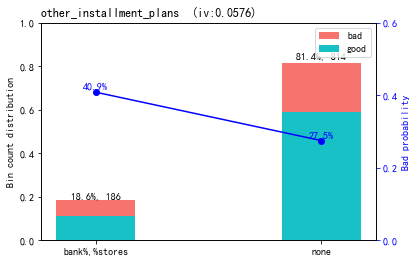

In [7]:
sc.woebin_plot(bins)

## 分箱调整

In [8]:
breaks_adj = {
    'age_in_years': [26, 35, 40],
    'other_debtors_or_guarantors': ["none", "co-applicant%,%guarantor"]
}

In [9]:
bins_adj = sc.woebin(dt_s, y="creditability", breaks_list=breaks_adj)

[INFO] creating woe binning ...


## WOE调整

In [11]:
train_woe = sc.woebin_ply(train, bins_adj)
test_woe = sc.woebin_ply(test, bins_adj)

[INFO] converting into woe values ...
[INFO] converting into woe values ...


## 搭建模型

In [17]:
y_train = train_woe.loc[:,'creditability']
X_train = train_woe.loc[:,train_woe.columns != 'creditability']
y_test = test_woe.loc[:,'creditability']
X_test = test_woe.loc[:,train_woe.columns != 'creditability']
# logistic regression -----
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='l1', C=0.9, solver='saga', n_jobs=-1)
lr.fit(X_train,y_train)

LogisticRegression(C=0.9, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=-1, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [22]:
#lr.coef_
#lr.intercept_
# predicted proability
train_pred = lr.predict_proba(X_train)[:,1]
test_pred = lr.predict_proba(X_test)[:,1]

## 模型评估

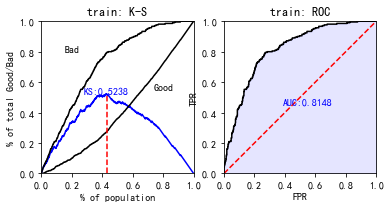

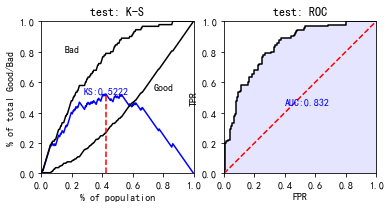

In [23]:
train_perf = sc.perf_eva(y_train, train_pred, title = "train")
test_perf = sc.perf_eva(y_test, test_pred, title = "test")

## 评分映射

In [25]:
card = sc.scorecard(bins_adj, lr, X_train.columns)
card['purpose']

,variable,bin,points
20,purpose,"retraining%,%car (used)",60.0
21,purpose,radio/television,31.0
22,purpose,"furniture/equipment%,%domestic appliances%,%bu...",-21.0


In [26]:
card['age_in_years']

,variable,bin,points
30,age_in_years,"[-inf,26.0)",-29.0
31,age_in_years,"[26.0,35.0)",-3.0
32,age_in_years,"[35.0,40.0)",31.0
33,age_in_years,"[40.0,inf)",11.0


In [29]:
train_score = sc.scorecard_ply(train, card, print_step=0)
test_score = sc.scorecard_ply(test, card, print_step=0)

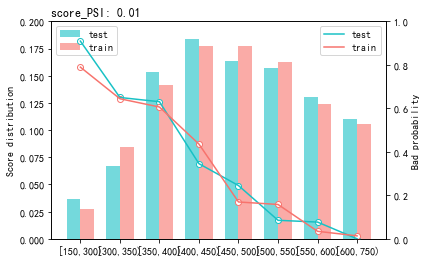

{'psi':   variable       PSI
 0    score  0.009959, 'pic': {'score': <Figure size 432x288 with 2 Axes>}}

In [30]:
sc.perf_psi(
  score = {'train':train_score, 'test':test_score},
  label = {'train':y_train, 'test':y_test}
)